In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'plant-disease-recognition-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1447507%2F2394131%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241005%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241005T091913Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D316f885e63c376f209177d8e12d86a6a5212c408d9a5892472d094fe13e457030a086045774be2674927704e341909db9919cf7b1895df037430cb59b097e1a3609173e6bb49e536e8646ca0434fe3bd4ac9991dbbc64a9250218aa4e58699cbc897ebc2db07a5c0916472a52330e7a9703eaa7bd7125f27510b8addb8e23f5b697c73adda1c2a6a5c3fc209b7bd03432bba2ab4574d617f07b431a315e8d11dfddeec0016fd6550e7a5f011f358a574ec7fa6b4b1561c8304511b94c9d0dd04ee748c2eae70e68a4a895e617e9d4fae77a5df2b8eb64c0d443daf7048e8e31fa5771129124098746d5c2974d8f2de730f1e7923c39057df42561fedc64496f8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1339624018 bytes downloaded
Downloaded and uncompressed: plant-disease-recognition-dataset
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Rust/955f62896264dbb2.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Rust/8196e2d8b66ed721.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Rust/8152cfbd5a28b5d2.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Rust/920e33d67f8b01b3.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Rust/879f394b2da49643.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Rust/8219aa662e8fd59d.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Rust/885f743de596e442.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Rust/902b269c0ddbe3e5.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Rust/879fc2e00f8274db.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Rust/851edcf908ed2e1c.jpg
/kaggle/input/plant-disease-recognition-

# **Rescaling all the images**

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_normalize = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_normalize = ImageDataGenerator(rescale=1./255)
val_normalize = ImageDataGenerator(rescale=1./255)

# **Load the images from their own directory**

In [4]:
train_set = train_normalize.flow_from_directory(directory="/kaggle/input/plant-disease-recognition-dataset/Train/Train",target_size=(225,225),class_mode='categorical')
val_set = val_normalize.flow_from_directory(directory="/kaggle/input/plant-disease-recognition-dataset/Validation/Validation",target_size=(225,225),class_mode="categorical")
test_set = test_normalize.flow_from_directory(directory="/kaggle/input/plant-disease-recognition-dataset/Test/Test",target_size=(225,225),class_mode="categorical")

Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


# **Import necessary libraries**

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Flatten,Dense,MaxPooling2D,Conv2D,Dropout

# **CNN model architecture **

In [6]:
model = Sequential()
model.add(Conv2D(64,(3,3),input_shape=(225,225,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# **Plot the model**

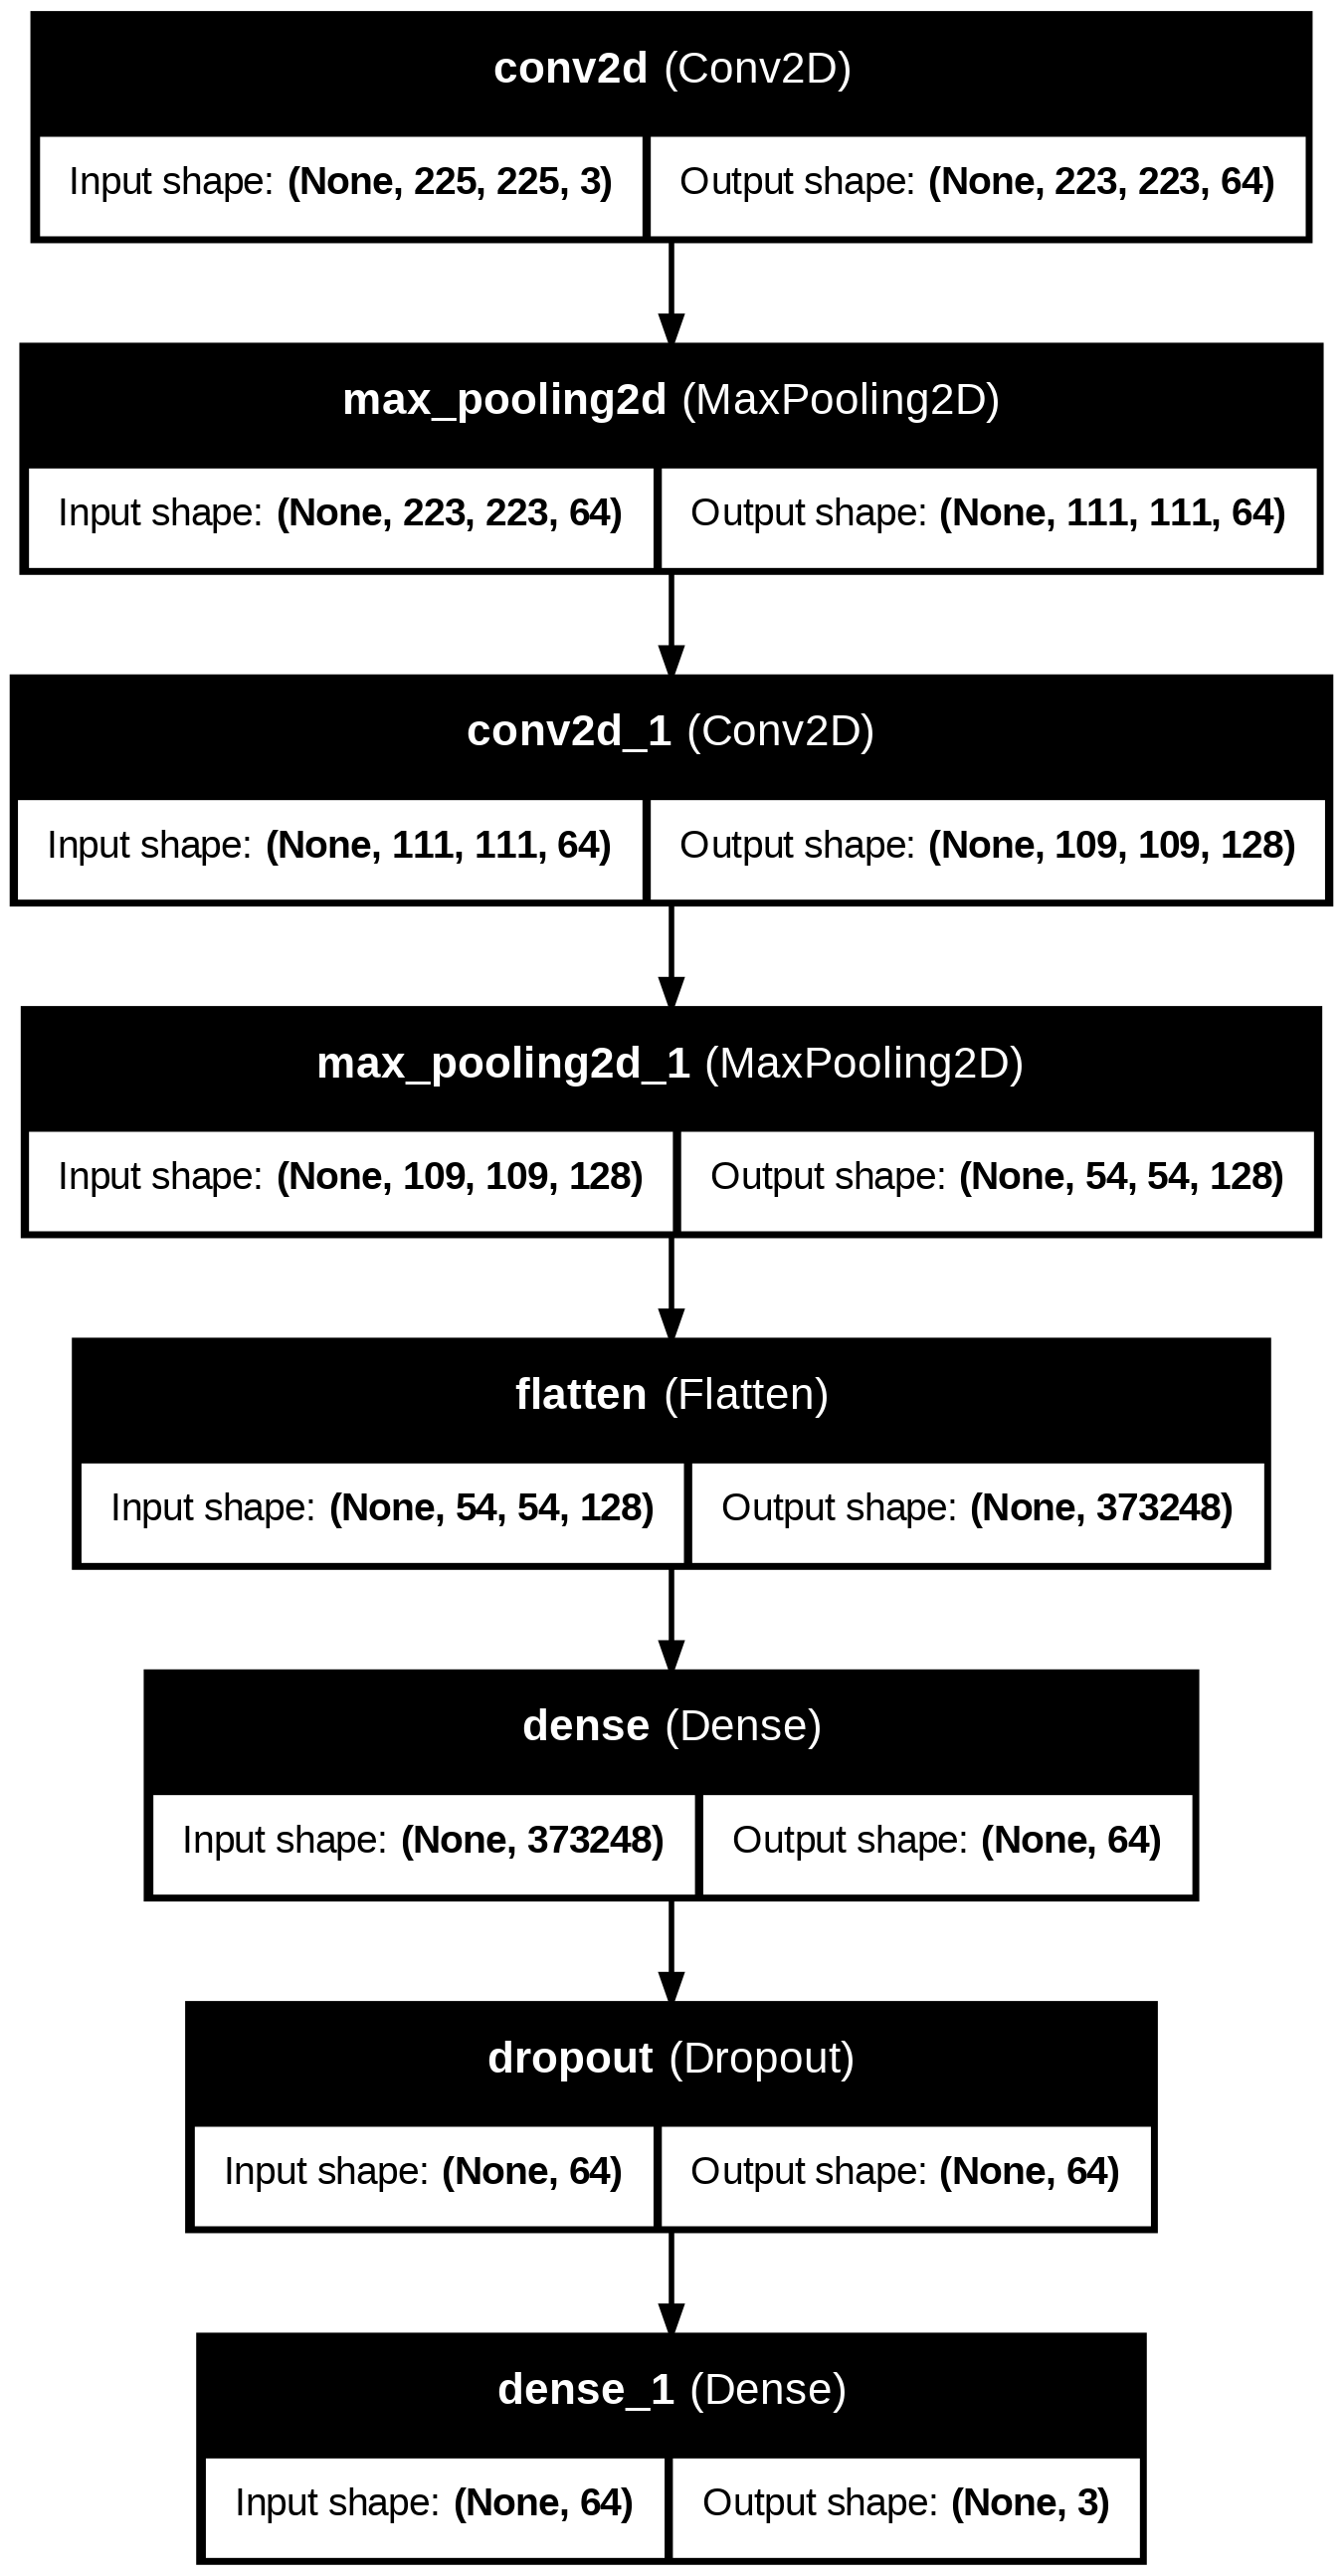

In [7]:
plot_model(model,show_layer_names=True,show_shapes=True)

# **Using categorical loss function with adam optimizer**

In [8]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# **fit the dataset into the model**

In [9]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_set, epochs=20, batch_size=16, validation_data=test_set, callbacks=[early_stopping])


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.4104 - loss: 3.9197 - val_accuracy: 0.5400 - val_loss: 0.9078
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.6743 - loss: 0.8060 - val_accuracy: 0.8333 - val_loss: 0.5165
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8279 - loss: 0.5102 - val_accuracy: 0.8800 - val_loss: 0.3394
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8718 - loss: 0.3615 - val_accuracy: 0.9067 - val_loss: 0.3353
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9022 - loss: 0.3025 - val_accuracy: 0.8200 - val_loss: 0.4682
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.8996 - loss: 0.3262 - val_accuracy: 0.9000 - val_loss: 0.3005
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9232 - loss: 0.2535 - val_accuracy: 0.8333 - val_loss: 0.4054
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9178 - loss: 0.2690 - val_accuracy: 0.8933 - val_loss: 0.

# **plot the performance**

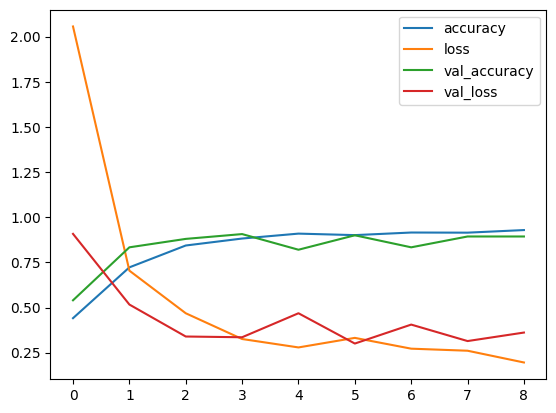

In [10]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot()
plt.show()

In [11]:
model.evaluate(val_set)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.8910 - loss: 0.3056


[0.33622655272483826, 0.8833333253860474]

In [12]:
model.evaluate(test_set)

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9141 - loss: 0.2644


[0.36131906509399414, 0.8933333158493042]

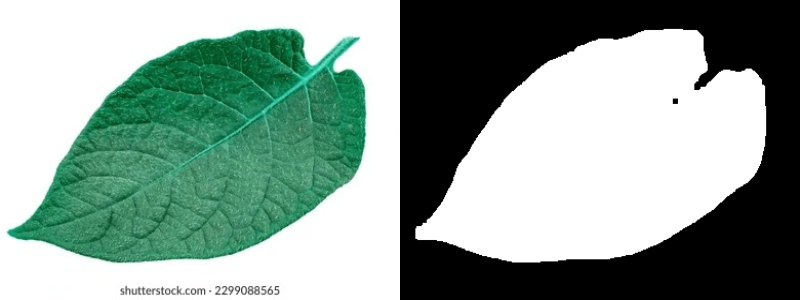

Leaves are present in the image.


In [21]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def segment_leaves(image):
    """
    Segment the leaves from the input image using color thresholding and morphological operations.

    Args:
    - image: Input image in RGB format.

    Returns:
    - mask: Binary mask representing the presence of leaves.
    """
    # Convert the image to HSV color space for better segmentation
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Define a more refined range of green color in HSV (adjusted for leaf green)
    lower_green = np.array([40, 60, 60])  # Adjusted lower bound for leaf green
    upper_green = np.array([80, 255, 255])  # Adjusted upper bound for leaf green

    # Create a binary mask where green colors are within the range
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Apply morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # Close small holes
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)   # Remove small noise

    return mask

def process_image(image_path):
    """
    Process the input image to detect leaves. Returns whether leaves are present or not.
    Displays the original image and the segmented mask image.

    Args:
    - image_path: Path to the input image.

    Returns:
    - True if leaves are present, False otherwise.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image at {image_path}")
        return False

    # Convert the image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform leaf segmentation
    mask = segment_leaves(image_rgb)

    # Find contours of the segmented leaves
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out small contours that are likely not leaves
    min_leaf_area = 1000  # Increased threshold for minimum area to consider as a leaf
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_leaf_area]

    # Calculate total green area to check for a significant presence of green
    total_green_area = sum(cv2.contourArea(cnt) for cnt in filtered_contours)

    # Consider leaves present if green areas cover more than 1% of the image
    image_area = image.shape[0] * image.shape[1]
    green_coverage_threshold = 0.01 * image_area

    # Resize the mask for better visibility
    mask_resized = cv2.resize(mask, (400, 300))  # Resize to 400x300 pixels
    image_resized = cv2.resize(image_rgb, (400, 300))  # Resize original image for consistency

    # Convert the mask to 3 channels to match the image
    mask_resized_3ch = cv2.cvtColor(mask_resized, cv2.COLOR_GRAY2BGR)
    #cv2.COLOR_GRAY2BGR converts a grayscale image to a 3-channel BGR image
    #This ensures 'mask_resized_3ch' has the same dimensions as 'image_resized'

    # Create a combined output image
    combined_output = np.hstack((image_resized, mask_resized_3ch))  # Horizontal stack

    # Display the combined image
    cv2_imshow(combined_output)  # Shows the original and the binary mask

    # Check if any significant leaves are detected
    if total_green_area > green_coverage_threshold:
        print("Leaves are present in the image.")
        return True
    else:
        print("Leaves are not present in the image.")
        return False

# Example usage
if __name__ == "__main__":
    image_path = '/content/image6.jpg'  # Replace with your image path
    result = process_image(image_path)


# **Prediction**

In [14]:
from tensorflow.keras.preprocessing.image import img_to_array,load_img

classes =train_set.class_indices
icd={i:j for j,i in classes.items()}
def output(location):
    img=load_img(location,target_size=(225,225,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    predict_x=model.predict(img)
    classes_x=np.argmax(predict_x,axis=1)
    print ('Pridicted Class',icd[classes_x[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Pridicted Class Rust


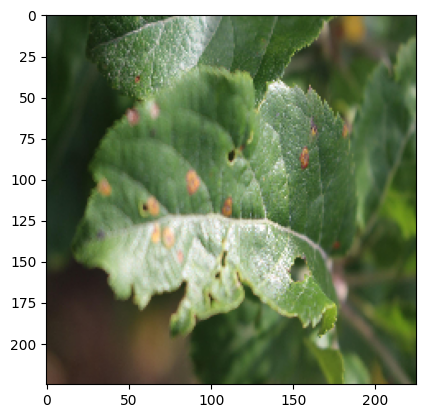

In [15]:
test_img='/kaggle/input/plant-disease-recognition-dataset/Test/Test/Rust/830f26cc6d3cd13e.jpg'
pic=load_img(test_img,target_size=(225,225,3))
plt.imshow(pic)
output(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Pridicted Class Powdery


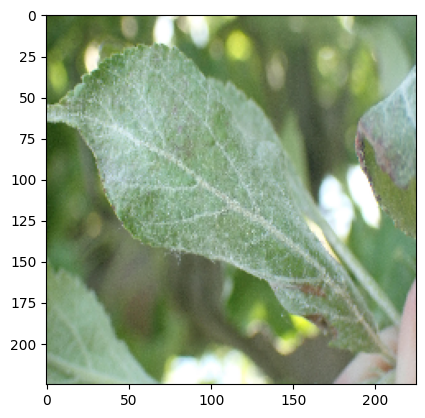

In [16]:
test_img='/kaggle/input/plant-disease-recognition-dataset/Test/Test/Powdery/81c36e378473c93e.jpg'
pic=load_img(test_img,target_size=(225,225,3))
plt.imshow(pic)
output(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Pridicted Class Healthy


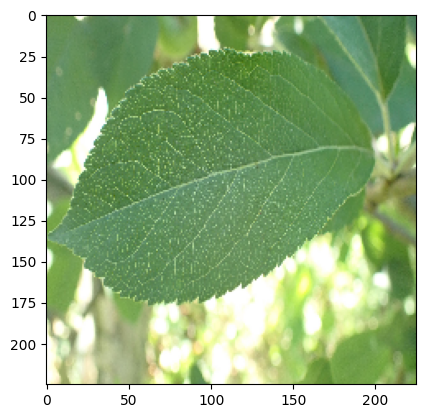

In [18]:
test_img='/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9d6acb154f9932c8.jpg'
pic=load_img(test_img,target_size=(225,225,3))
plt.imshow(pic)
output(test_img)

In [54]:
model.save('leaf_disease_model.h5')

In [20]:
!pip install pyngrok


In [21]:
!ngrok config add-authtoken "2mq8gi9mLq9WeflF6VjEgHiqCaI_5nfU6J6MaaF1KK4nmojZ9"

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [22]:
from pyngrok import ngrok

# Start an ngrok tunnel
public_url = ngrok.connect(5000)
print(f"Public URL: {public_url}")


Public URL: NgrokTunnel: "https://a753-34-83-36-107.ngrok-free.app" -> "http://localhost:5000"


In [23]:
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
from io import BytesIO
from pyngrok import ngrok

# Load your trained model
model = load_model('leaf_disease_model.h5')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create a Flask app
app = Flask(__name__)

# Mapping of class indices to class names
classes = {'healthy': 0, 'rusty': 1, 'powdery': 2}
icd = {v: k for k, v in classes.items()}

# Function to make predictions
def predict_class(image):
    # Resize and preprocess the image
    image = image.resize((225, 225))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    # Make predictions
    predictions = model.predict(image)
    predicted_class = np.argmax(predictions, axis=1)[0]

    return icd[predicted_class]

# Root route
@app.route('/')
def home():
    return "Leaf Disease Prediction API is running."

# Favicon route
@app.route('/favicon.ico')
def favicon():
    return '', 204

# Route for prediction
@app.route('/predict', methods=['POST'])
def predict():
    # Check if the image is part of the request
    if 'file' not in request.files:
        return jsonify({'error': 'No file uploaded'}), 400

    # Get the image file from the request
    file = request.files['file']

    try:
        # Open the image from the file (in memory)
        image = Image.open(BytesIO(file.read()))
    except Exception as e:
        return jsonify({'error': f'Invalid image: {str(e)}'}), 400

    # Predict the class of the image
    predicted_class = predict_class(image)

    # Return the result as JSON
    return jsonify({'predicted_class': predicted_class})

# Main function to run the app
if __name__ == '__main__':
    # Start the Flask app
    public_url = ngrok.connect(5000)  # Expose the Flask app via ngrok
    print(f"Public URL: {public_url}")
    app.run(host='0.0.0.0', port=5000)


Public URL: NgrokTunnel: "https://af51-34-83-36-107.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit


# **Coclusion**

# Our CNN model predict the diseases perfectly.